# Main

## Refs
- https://github.com/tanjimin/grad-cam-pytorch-light/
- https://github.com/chr5tphr/zennit/
- https://github.com/utkuozbulak/pytorch-cnn-visualizations/
- https://github.com/jacobgil/pytorch-grad-cam/

## Imports

In [121]:
import cv2
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import os
from pathlib import Path
import math

## Utils

In [232]:
def get_2d_projection(activation_batch):
    # TBD: use pytorch batch svd implementation
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshaped_activations = reshaped_activations - \
            reshaped_activations.mean(axis=0)
        U, S, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
        projection = reshaped_activations @ VT[0, :]
        projection = projection.reshape(activations.shape[1:])
        projections.append(projection)
    return np.float32(projections)

In [252]:
def plot_image_grid(images, titles=None, image_title=None):
    # if single image plot it
    if len(images) == 1:
        plt.imshow(images[0])
        if titles:
            plt.title(titles[0])
    # else plot them in a grid layout with automatic number of rows and columns
    else:
        rows = math.ceil(len(images)/3)
        columns = 4
        fig=plt.figure(figsize=(8, 8))
        plt.title(image_title)

        plt.axis('off')
        for i in range(1, len(images)+1):
            fig.add_subplot(rows, columns, i)
            plt.axis('off')
            plt.imshow(images[i-1])
            if titles:
                plt.title(titles[i-1])
    
    return plt


In [2]:

class InfoHolder():

    def __init__(self, heatmap_layer):
        self.gradient = None
        self.activation = None
        self.heatmap_layer = heatmap_layer

    def get_gradient(self, grad):
        self.gradient = grad

    def hook(self, model, input, output):
        output.register_hook(self.get_gradient)
        self.activation = output.detach()


In [3]:

def generate_heatmap(weighted_activation):
    raw_heatmap = torch.mean(weighted_activation, 0)
    heatmap = np.maximum(raw_heatmap.detach().cpu(), 0)
    heatmap /= torch.max(heatmap) + 1e-10
    return heatmap.numpy()


In [4]:

def superimpose(input_img, heatmap):
    img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * 0.6 + img * 0.4)
    pil_img = cv2.cvtColor(superimposed_img,cv2.COLOR_BGR2RGB)
    return pil_img


In [5]:

def to_RGB(tensor):
    tensor = (tensor - tensor.min())
    tensor = tensor/(tensor.max() + 1e-10)
    image_binary = np.transpose(tensor.numpy(), (1, 2, 0))
    image = np.uint8(255 * image_binary)
    return image


## Algos

In [68]:
def cam(model, input_tensor, heatmap_layer, truelabel=None):
    info = InfoHolder(heatmap_layer)
    hook = heatmap_layer.register_forward_hook(info.hook)

    output = model(input_tensor.unsqueeze(0))[0]
    output[torch.argmax(output)].backward()

    heatmap = generate_heatmap(info.gradient[0])
    weights = torch.mean(info.gradient, [0, 2, 3])
    activation = info.activation.squeeze(0)

    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = weight * activation

    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)


In [64]:
def grad_cam(model, input_tensor, heatmap_layer, truelabel=None):
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    
    output = model(input_tensor.unsqueeze(0))[0]
    truelabel = truelabel if truelabel else torch.argmax(output)

    output[truelabel].backward()

    weights = torch.mean(info.gradient, [0, 2, 3])
    activation = info.activation.squeeze(0)

    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = weight * activation

    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)


In [95]:
def gradcamelementwise(model, input_tensor, heatmap_layer, truelabel=None):
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    
    output = model(input_tensor.unsqueeze(0))[0]
    truelabel = truelabel if truelabel else torch.argmax(output)

    output[truelabel].backward()

    weights = torch.mean(info.gradient, [0, 2, 3])
    activation = info.activation.squeeze(0)

    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        wa = weight * activation
        weighted_activation[idx] = torch.where(wa > 0, wa, 0)

    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)


In [237]:
def xgrad_cam(model, input_tensor, heatmap_layer, truelabel=None):
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    
    output = model(input_tensor.unsqueeze(0))[0]
    truelabel = truelabel if truelabel else torch.argmax(output)

    output[truelabel].backward()

    weights = torch.mean(info.gradient, [0, 2, 3])
    activation = info.activation.squeeze(0)

    weighted_activation = torch.zeros(activation.shape)
    sum_activations = torch.sum(activation, dim=(1, 2))

    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        # weighted_activation[idx] = weight * activation
        weighted_activation[idx] = weight * activation / sum_activations[idx]
    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)


In [243]:
def eigen_cam(model, input_tensor, heatmap_layer, truelabel=None):
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    
    output = model(input_tensor.unsqueeze(0))[0]
    truelabel = truelabel if truelabel else torch.argmax(output)

    output[truelabel].backward()

    weights = torch.mean(info.gradient, [0, 2, 3])
    # activation = info.activation.squeeze(0)

    weighted_activation = torch.Tensor(get_2d_projection(np.array(info.activation)))
    # print(weighted_activation.shape)
    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)


In [264]:
def relu_deconvnet(model, input_tensor, heatmap_layer, truelabel=None):
    # @zeiler2014visualizing
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    
    output = model(input_tensor.unsqueeze(0))[0]
    truelabel = truelabel if truelabel else torch.argmax(output)

    output[truelabel].backward()

    weights = torch.mean(info.gradient, [0, 2, 3]) #grad_input
    activation = info.activation.squeeze(0) #grad_output

    # weighted_activation = torch.zeros(activation.shape)
    # for idx, (weight, activation) in enumerate(zip(weights, activation)):
    #     weighted_activation[idx] = weight * activation
    weighted_activation = activation.clamp(min=0) 

    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)


In [265]:
def relu_guidedbackprop(model, input_tensor, heatmap_layer, truelabel=None):
    # @springenberg2015striving
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    
    output = model(input_tensor.unsqueeze(0))[0]
    truelabel = truelabel if truelabel else torch.argmax(output)

    output[truelabel].backward()

    weights = torch.mean(info.gradient, [0, 2, 3]) #grad_input
    activation = info.activation.squeeze(0) #grad_output

    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = weight * torch.where(activation > 0, activation, torch.zeros(activation.shape))

    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)


In [275]:
def relu_betasmooth(model, input_tensor, heatmap_layer, truelabel=None, beta_smooth=10.):
    # @dombrowski2019explanations
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    
    output = model(input_tensor.unsqueeze(0))[0]
    truelabel = truelabel if truelabel else torch.argmax(output)

    output[truelabel].backward()

    weights = torch.mean(info.gradient, [0, 2, 3]) #grad_input
    activation = info.activation.squeeze(0) #grad_output

    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = torch.sigmoid(beta_smooth * weight) * activation

    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)


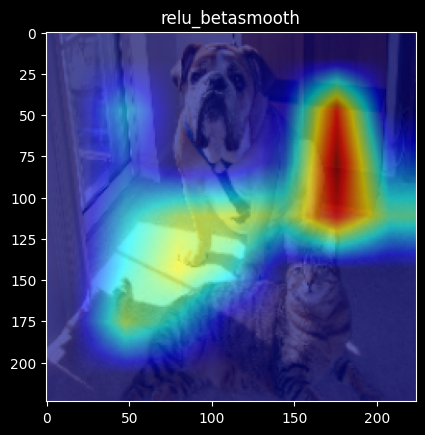

In [276]:
cat_example(relu_betasmooth, image_path, label, model)

## Demo

In [277]:
def cat_example(attribution_method, image_path, label, model, save_path=None):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(240),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    heatmap_layer = model.layer4[2].conv2
    attrbs = []
    attrib_labels = []
    image = Image.open(image_path)
    input_tensor = transform(image)
    if type(attribution_method) != list:
        attribution_method = [attribution_method]

    for method in attribution_method:
        image = method(model, input_tensor, heatmap_layer, label)
        attrbs.append(image)
        attrib_labels.append(method.__name__)
    
    plt = plot_image_grid(attrbs, attrib_labels, f"Comparison of Methods\nLabel : {label}")
    if save_path:
        plt.savefig(save_path)

In [278]:
all_methods = [cam, grad_cam, gradcamelementwise, xgrad_cam, eigen_cam, relu_deconvnet, relu_guidedbackprop, relu_betasmooth]

torch.Size([512, 7, 7])


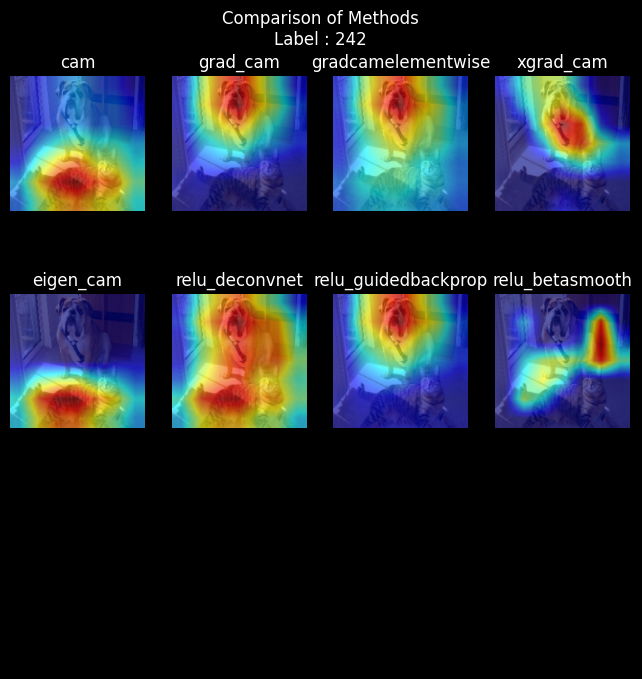

In [279]:
model = torchvision.models.resnet34(pretrained=True)
image_path = "./images/cat_dog.png"
label = 242
cat_example(all_methods, image_path, label, model, save_path="./images/cat_dog_results.png")

## TODO

In [ ]:
def batch_image_prediction(image_path, attribution_method = grad_cam, label = None, plot = False):
    model = torchvision.models.resnet34(pretrained=True)
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(240),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
    heatmap_layer = model.layer4[2].conv2
    images = []

    # if image_path is a folder
    if os.path.isdir(image_path):
        dataset = torchvision.datasets.ImageFolder(image_path, transform=transform)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4)
        for batch in dataloader:
            inputs, labels = batch
            attributions = attribution_method(model, inputs, heatmap_layer, labels)
            images.append(attributions)
        
    elif os.path.isfile(image_path):
        # if image_path is a file
        image = Image.open(image_path)
        input_tensor = transform(image)
        attribution = attribution_method(model, input_tensor, heatmap_layer, label)
        images.append(attribution)
    
    if plot == True:
        plot_images(images)
    return images if len(images) > 1 else images[0]
pred = batch_image_prediction(image_path='./images', attribution_method=grad_cam, label=242, plot=True)